In [ ]:
#ip: 168.188.128.36
#port: 20370:22, 20371:8888
#putty의 설정 source port:8888 Destination : localhost:8888 저장
#jupyter notebook --no-browser --allow-root
#나오는 토큰 설정의 구성된 서버에 입력


In [1]:
import torch

from shap_e.diffusion.sample import sample_latents
from shap_e.diffusion.gaussian_diffusion import diffusion_from_config
from shap_e.models.download import load_model, load_config
from shap_e.util.notebooks import create_pan_cameras, decode_latent_images, gif_widget
from shap_e.util.notebooks import decode_latent_mesh

In [2]:
if torch.cuda.is_available():
    print("GPU 사용 가능")
    print("GPU 이름:", torch.cuda.get_device_name(0))
    print("현재 디바이스:", torch.cuda.current_device())
else:
    print("GPU 사용 불가")


GPU 사용 가능
GPU 이름: Tesla P100-PCIE-16GB
현재 디바이스: 0


In [3]:
#nvidia-smi gpu 상태 확인
device = torch.device('cuda:6' if torch.cuda.is_available() else 'cpu')

In [4]:
!nvidia-smi
!rm -rf /root/hongdyu/hongdyu/shap_e_model_cache/text_cond.pt

Thu May  8 14:12:21 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:04:00.0 Off |                    0 |
| N/A   68C    P0             201W / 250W |  11810MiB / 16384MiB |    100%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
xm = load_model('transmitter', device=device)
shap_e_model = load_model('text300M', device=device)
diffusion = diffusion_from_config(load_config('diffusion'))

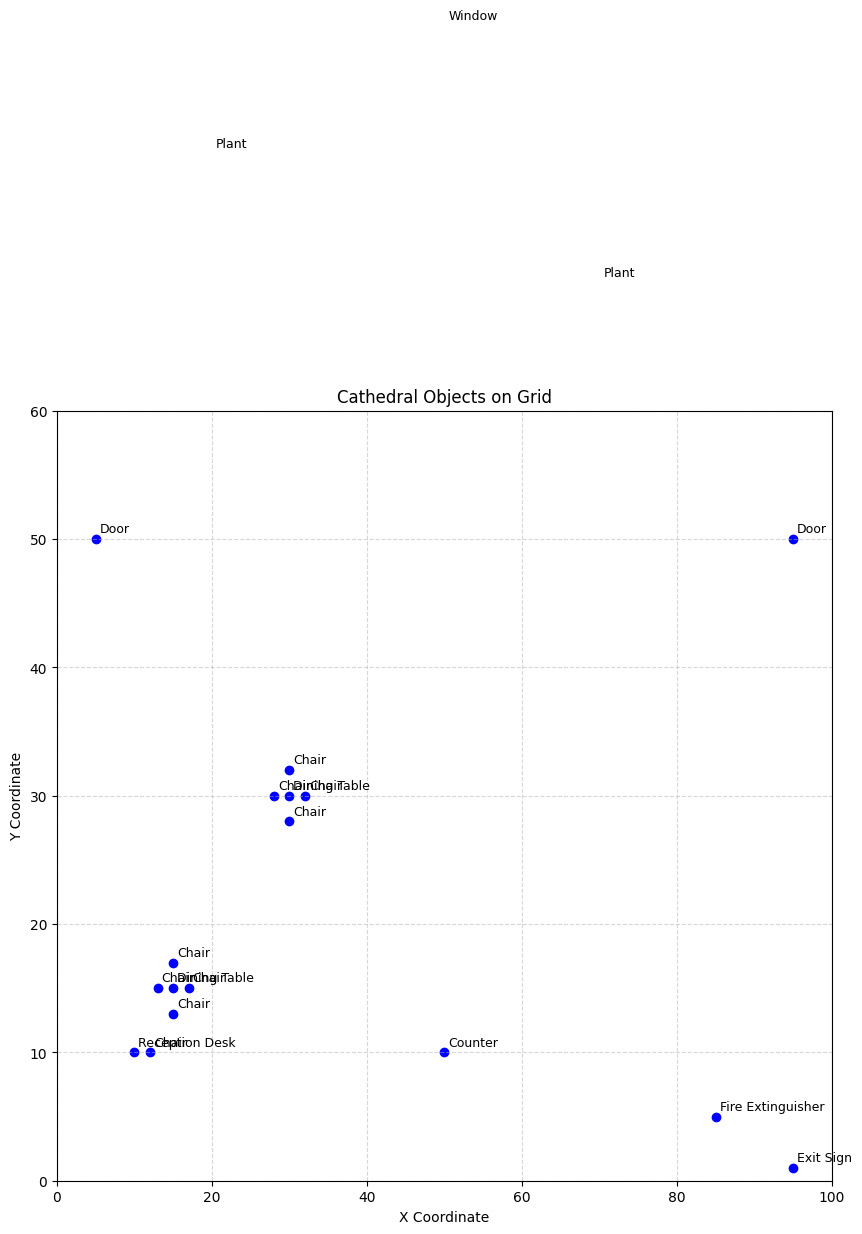

In [6]:
import hongdyu_gpt

In [7]:
for i in range(len(hongdyu_gpt.object_names)):
    name = hongdyu_gpt.object_names[i]
    print(name)
    batch_size = 1
    guidance_scale = 15.0
    prompt = hongdyu_gpt.object_names[i]
    latents = sample_latents(
      batch_size=batch_size,
      model=shap_e_model,
      diffusion=diffusion,
      guidance_scale=guidance_scale,
      model_kwargs=dict(texts=[prompt] * batch_size),
      progress=True,
      clip_denoised=True,
      use_fp16=True,
      use_karras=True,
      karras_steps=64,
      sigma_min=1e-3,
      sigma_max=160,
      s_churn=0,
    )
    render_mode = 'nerf' # you can change this to 'stf'
    size = 64 # this is the size of the renders; higher values take longer to render.

    cameras = create_pan_cameras(size, device)
    image = decode_latent_images(xm, latents, cameras, rendering_mode=render_mode)
    display(gif_widget(image))

Dining Table


  0%|          | 0/64 [00:00<?, ?it/s]

HTML(value='<img src="data:image/gif;base64,R0lGODlhQABAAIYAADEeEC8fDTEdEDEdDzAdEDAdDzEcDzAcDzAcDi8cDy8cDi4cDy…

Chair


  0%|          | 0/64 [00:00<?, ?it/s]

HTML(value='<img src="data:image/gif;base64,R0lGODlhQABAAIcAAGE8AF47AF46AF06AF05AFw5AFw4AVw4AFs4AVs4AFo4AVs3AV…

Chair


  0%|          | 0/64 [00:00<?, ?it/s]

HTML(value='<img src="data:image/gif;base64,R0lGODlhQABAAIYAAFU8AVU8AFQ7AVQ7AFM7AFI7AFM6AVM6AFI6AFM5AFI5AVI5AF…

Chair


  0%|          | 0/64 [00:00<?, ?it/s]

HTML(value='<img src="data:image/gif;base64,R0lGODlhQABAAIcAAEQnD0MnET4pF0MmEUImEEMmDkMmDUEmED8mEEIlDUElDkIlDE…

Chair


  0%|          | 0/64 [00:00<?, ?it/s]

HTML(value='<img src="data:image/gif;base64,R0lGODlhQABAAIcAAFY3H1Q2H1M2H1M1H1M1HVI1H1I0HVE0HlE0HFEzHFA0HlAzHV…

Dining Table


  0%|          | 0/64 [00:00<?, ?it/s]

HTML(value='<img src="data:image/gif;base64,R0lGODlhQABAAIYAAFE5BlA5B1A5BlA4B1A4Bk84Bk84BU83Bk83BU43B043Bk43BU…

Chair


  0%|          | 0/64 [00:00<?, ?it/s]

HTML(value='<img src="data:image/gif;base64,R0lGODlhQABAAIcAALK1sbK0sLGzsrCzr7GysrGysbGysLCysa+yrq+yrbCxsK+xra…

Chair


  0%|          | 0/64 [00:00<?, ?it/s]

HTML(value='<img src="data:image/gif;base64,R0lGODlhQABAAIcAAGpeT2leT2ldT2hdT2lcT2lcTmhcT2hcTmdcT2dcTmhbTmdbT2…

Chair


  0%|          | 0/64 [00:00<?, ?it/s]

HTML(value='<img src="data:image/gif;base64,R0lGODlhQABAAIcAAFM2BlM2BVI2BlI1BlI1BVE1BlE1BVM2AlM2AVI2AlI2AVI1Al…

Chair


  0%|          | 0/64 [00:00<?, ?it/s]

HTML(value='<img src="data:image/gif;base64,R0lGODlhQABAAIcAAO3u7uzu7+vq6+vq6urq6unq6+rp6unp6unp6ejp6efp6uno6e…

Door


  0%|          | 0/64 [00:00<?, ?it/s]

HTML(value='<img src="data:image/gif;base64,R0lGODlhQABAAIYAAFM4KlI4KlE3K1E3KlA3LlA3LVE2K1A2LFA2K1A2KlA2KU83LU…

Door


  0%|          | 0/64 [00:00<?, ?it/s]

HTML(value='<img src="data:image/gif;base64,R0lGODlhQABAAIYAAEYyIEYyH0YyHkYxIEYxH0UxH0YxHkUxHkUxHUQxHkUwH0UwHk…

Counter


  0%|          | 0/64 [00:00<?, ?it/s]

HTML(value='<img src="data:image/gif;base64,R0lGODlhQABAAIcAAJ2mq52mqpymq5ymqp2lq5ylq5ylqpulq5ulqpykq5ykqpukq5…

Window


  0%|          | 0/64 [00:00<?, ?it/s]

HTML(value='<img src="data:image/gif;base64,R0lGODlhQABAAIcAAJ+ipZ6ipZqcoJmcoZmcoJmcnpicopiboJaboZianZeanpeanZ…

Plant


  0%|          | 0/64 [00:00<?, ?it/s]

HTML(value='<img src="data:image/gif;base64,R0lGODlhQABAAIcAAEttLUtpK0VsJEJpJURnJ0FnJEBnIVFjLUdlJ0VlJ0JkI0BgJD…

Plant


  0%|          | 0/64 [00:00<?, ?it/s]

HTML(value='<img src="data:image/gif;base64,R0lGODlhQABAAIcAAE14LU90JUt1KU9zIk5yIUtyKUlyH01wIEpwIkhwIUhwHUdwH0…

Reception Desk


  0%|          | 0/64 [00:00<?, ?it/s]

HTML(value='<img src="data:image/gif;base64,R0lGODlhQABAAIcAANa5n9S4n9a3m9e2l9m1l9m1ldi1lti1lde1l9e1lta1l9a1lt…

Chair


  0%|          | 0/64 [00:00<?, ?it/s]

HTML(value='<img src="data:image/gif;base64,R0lGODlhQABAAIcAAFM5AFI5AFE5AFE4AFA4AFE3AFA3AE44AE83AE43AFA2AE82AE…

Exit Sign


  0%|          | 0/64 [00:00<?, ?it/s]

HTML(value='<img src="data:image/gif;base64,R0lGODlhQABAAIYAAJiZmZiZmJeZmZeZmJiYmJeYmJeXmJeXl5eWmJaWmJaWl5SUlp…

Fire Extinguisher


  0%|          | 0/64 [00:00<?, ?it/s]

HTML(value='<img src="data:image/gif;base64,R0lGODlhQABAAIcAALy8tLq4sba1q7GvpaqonbCknKikmLKdlqmdka+UjKWVjJiSja…

In [11]:
print("python version:",sys.version)
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)

python version: 3.10.12 (main, Feb  4 2025, 14:57:36) [GCC 11.4.0]
Torch version: 2.0.1+cu117
CUDA available: True
CUDA version: 11.7


In [15]:
import os
import sys
import torch

need_pytorch3d = False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d = True

if need_pytorch3d:
    # PyTorch 2.0.1 + cu117 + Python 3.10
    version_str = "py310_cu117_pyt201"  # Python 3.10, CUDA 11.7, PyTorch 2.0.1

    # 필수 의존성 설치
    !pip install -U fvcore iopath

    # PyTorch3D wheel 설치
    !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html


In [16]:
batch_size = 1
guidance_scale = 15.0
prompt = "a shark"

latent = sample_latents(
    batch_size=batch_size,
    model=shap_e_model,
    diffusion=diffusion,
    guidance_scale=guidance_scale,
    model_kwargs=dict(texts=[prompt] * batch_size),
    progress=True,
    clip_denoised=True,
    use_fp16=True,
    use_karras=True,
    karras_steps=64,
    sigma_min=1e-3,
    sigma_max=160,
    s_churn=0,
)
for i, latent in enumerate(latent):
    t = decode_latent_mesh(xm, latent).tri_mesh()
    with open(f'example_mesh_{i}.ply', 'wb') as f:
        t.write_ply(f)
    with open(f'example_mesh_{i}.obj', 'w') as f:
        t.write_obj(f)

  0%|          | 0/64 [00:00<?, ?it/s]

In [20]:
import os
print(os.getcwd())
!ls

/tmp/pycharm_project_331/hongdyu/renders
243_25659_43-pycharm-support-libs  hongdyu_gpt.py  shap-e.ipynb
example_mesh_0.obj		   pytorch3d	   shap.py
example_mesh_0.ply		   render_0.gif    shap_e_model_cache
